### Description 

This project performs a time series analysis and prediction of stock price using LSTM.

## Part 1: Data loading & exploration
### 1.1 Preprocessing (normalization)

The data contains a history of 150 days of APPL. First, preprocess the data for use with our model

In [1]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2020-09-20 12:47:37--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M  74.6MB/s    in 0.4s    

2020-09-20 12:47:38 (74.6 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [2]:
!ls .

all_stocks_5yr.csv  sample_data


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install torch
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [4]:
# Importing the training set
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='SWKS'].close.values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Part 2:  Time series segmentation

We can treat the time series prediction problem as a regression problem, hence we need to cut the series into pieces in order to apply our model

In [6]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


## Part 3: Split training and testing sets



In [7]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


## Part 4:  Build and run an RNN regression model

Using Keras to set up a two hidden layer RNN:
  - layer 1 uses and LSTM module with 5 hidden units
  - layer 2 uses a fully connected module with one unit
  - use MSE as our loss function

In [8]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [9]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [10]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.16063907742500305, eval loss 0.5001010894775391
epoch 1, loss 0.14192374050617218
epoch 2, loss 0.12446314096450806
epoch 3, loss 0.10815636068582535
epoch 4, loss 0.09325005859136581
epoch 5, loss 0.07984400540590286
epoch 6, loss 0.06824441254138947
epoch 7, loss 0.0598384365439415
epoch 8, loss 0.05760418251156807
epoch 9, loss 0.060530681163072586
epoch 10, loss 0.06469206511974335
epoch 11, loss 0.06403744965791702
epoch 12, loss 0.058708157390356064
epoch 13, loss 0.052014514803886414
epoch 14, loss 0.04666827991604805
epoch 15, loss 0.042635682970285416
epoch 16, loss 0.04017156735062599
epoch 17, loss 0.03719509765505791
epoch 18, loss 0.03383466228842735
epoch 19, loss 0.02960609644651413
epoch 20, loss 0.024525437504053116, eval loss 0.023796983063220978
epoch 21, loss 0.019092882052063942
epoch 22, loss 0.015922268852591515
epoch 23, loss 0.016516676172614098
epoch 24, loss 0.015086897648870945
epoch 25, loss 0.010934242978692055
epoch 26, loss 0.008091868832

In [12]:
rnn.out.weight 

Parameter containing:
tensor([[-0.1136, -0.0049, -0.0863,  0.0839, -0.0431,  0.0720, -0.0754,  0.0587,
          0.0388, -0.0890,  0.0887,  0.0521,  0.0298, -0.0561, -0.0076,  0.0679,
         -0.0869, -0.1098,  0.1289,  0.1051, -0.0713,  0.0983, -0.0061, -0.0013,
          0.0399,  0.1140, -0.0728,  0.1209, -0.0054,  0.0936, -0.1109,  0.1325,
         -0.1052, -0.0177,  0.0295,  0.1134, -0.1144,  0.0241,  0.0193, -0.1014,
         -0.0460, -0.0415,  0.0890, -0.0245, -0.0257,  0.0975,  0.0064,  0.0185,
         -0.0383,  0.0981, -0.0201,  0.0518,  0.0217, -0.1181,  0.0744, -0.0941,
          0.0706, -0.0512, -0.0367, -0.1284, -0.0883,  0.0660, -0.0860, -0.0753]],
       device='cuda:0', requires_grad=True)

In [13]:
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0826,  0.0138, -0.0111,  ...,  0.1121,  0.0800,  0.0183],
        [ 0.1293, -0.0042, -0.0208,  ..., -0.0743,  0.1239,  0.0805],
        [ 0.0003,  0.0441,  0.0333,  ..., -0.1145,  0.0070, -0.0206],
        ...,
        [-0.0935, -0.0190,  0.0421,  ..., -0.0841,  0.0660, -0.1582],
        [ 0.0212,  0.0652, -0.0722,  ..., -0.0202,  0.1602,  0.1626],
        [-0.0556, -0.0478, -0.0030,  ...,  0.0963,  0.1304,  0.0737]],
       device='cuda:0')
tensor([[-0.0217,  0.0502,  0.0262,  ..., -0.0307,  0.0354,  0.0415],
        [-0.0054,  0.0026,  0.0055,  ..., -0.1507, -0.0599,  0.1254],
        [-0.0904, -0.0870,  0.0055,  ..., -0.0973, -0.0118, -0.0754],
        ...,
        [-0.0666, -0.1163,  0.0361,  ..., -0.1056, -0.0274,  0.0839],
        [ 0.0590,  0.0608, -0.0022,  ...,  0.1008,  0.0355, -0.0264],
        [ 0.0816, -0.0806, -0.0305,  ...,  0.0831,  0.1242, -0.0709]],
       device='cuda:0')
tensor([ 0.1208,  0.0989,  0.0263,  0.0844,  0.0881,  0.1324,  0.0899,  0.1064,
    

## Part 5: Checking model performance

Make prediction on training and testing dataset

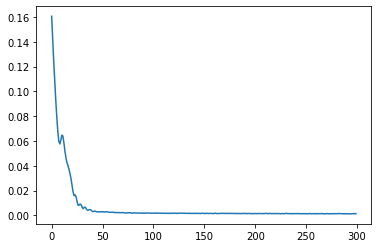

In [14]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [15]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [16]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [17]:
test_predict_cpu.shape

(251, 1, 1)

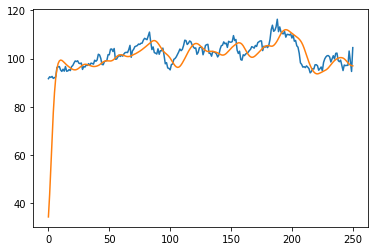

In [18]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

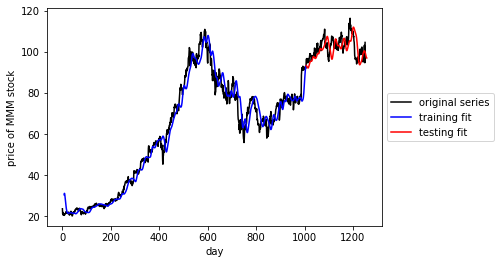

In [19]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
